In [3]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from skimage import io
import tensorflow as tf



# Audio Data Preprocessing

In [4]:
hdf5_file= 'D:/big data/practice/big_data_project/data/EPIC_audio.hdf5'
csv_file = 'D:/big data/practice/big_data_project/data/EPIC_Sounds_train.csv'


In [5]:
hdf5_data = h5py.File(hdf5_file, "r")
metadata = pd.read_csv(csv_file)

In [6]:
metadata.head(10)

annotation_id participant_id video_id start_timestamp stop_timestamp  \
0      P01_01_0            P01   P01_01    00:00:02.466   00:00:05.315   
1      P01_01_1            P01   P01_01    00:00:08.981   00:00:09.871   
2      P01_01_2            P01   P01_01    00:00:10.190   00:00:12.731   
3      P01_01_3            P01   P01_01    00:00:14.023   00:00:15.044   
4      P01_01_4            P01   P01_01    00:00:15.148   00:00:19.729   
5      P01_01_5            P01   P01_01    00:00:16.924   00:00:17.549   
6      P01_01_6            P01   P01_01    00:00:22.002   00:00:22.382   
7      P01_01_7            P01   P01_01    00:00:24.836   00:00:27.002   
8      P01_01_8            P01   P01_01    00:00:26.877   00:00:28.077   
9      P01_01_9            P01   P01_01    00:00:27.981   00:00:28.641   

   start_sample  stop_sample                    description  \
0         59184       127560                clang / clatter   
1        215544       236904          put object on surface   
2        244560       305544                       footstep   
3        336552       361056  scrub / scrape / scour / wipe   
4        363552       473496                   paper rustle   
5        406176       421176                clang / clatter   
6        528048       537168                clang / clatter   
7        596064       648048                clang / clatter   
8        645048       673848                   paper rustle   
9        671544       687384                clang / clatter   

                           class  class_id  
0         plastic-only collision         6  
1                   open / close         3  
2                       footstep         7  
3  scrub / scrape / scour / wipe         1  
4                         rustle         4  
5           paper-only collision        18  
6         plastic-only collision         6  
7         plastic-only collision         6  
8                         rustle         4  
9         plastic-only collision         6

In [5]:

# List the keys in the HDF5 file
print(list(hdf5_data.keys()))

# Inspect the structure for a specific key
if "participant_id" in hdf5_data and "video_id" in hdf5_data["participant_id"]:
    print(list(hdf5_data["participant_id"]["video_id"].keys()))
else:
    print("Keys not found in the HDF5 file structure.")

['P01_01', 'P01_02', 'P01_03', 'P01_04', 'P01_05', 'P01_06', 'P01_07', 'P01_08', 'P01_09', 'P01_10', 'P01_101', 'P01_102', 'P01_103', 'P01_104', 'P01_105', 'P01_106', 'P01_107', 'P01_108', 'P01_109', 'P01_11', 'P01_12', 'P01_13', 'P01_14', 'P01_15', 'P01_16', 'P01_17', 'P01_18', 'P01_19', 'P02_01', 'P02_02', 'P02_03', 'P02_04', 'P02_05', 'P02_06', 'P02_07', 'P02_08', 'P02_09', 'P02_10', 'P02_101', 'P02_102', 'P02_103', 'P02_104', 'P02_105', 'P02_106', 'P02_107', 'P02_108', 'P02_109', 'P02_11', 'P02_110', 'P02_111', 'P02_112', 'P02_113', 'P02_114', 'P02_115', 'P02_116', 'P02_117', 'P02_118', 'P02_119', 'P02_12', 'P02_120', 'P02_121', 'P02_122', 'P02_123', 'P02_124', 'P02_125', 'P02_126', 'P02_127', 'P02_128', 'P02_129', 'P02_13', 'P02_130', 'P02_131', 'P02_132', 'P02_133', 'P02_134', 'P02_135', 'P02_136', 'P02_137', 'P02_14', 'P02_15', 'P03_01', 'P03_02', 'P03_03', 'P03_04', 'P03_05', 'P03_06', 'P03_07', 'P03_08', 'P03_09', 'P03_10', 'P03_101', 'P03_102', 'P03_103', 'P03_104', 'P03_105'

# Extract Features

In [7]:
# Function to extract audio features
def extract_audio_features(audio_array, start_sample, stop_sample):
    audio_segment = audio_array[start_sample:stop_sample]
    mfcc_features = librosa.feature.mfcc(y=audio_segment, sr=44100, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfcc_features.T,axis=0)
    return mfccs_scaled_features


In [8]:
# Function to extract log-mel spectrogram
def extract_log_mel_spectrogram(audio_array, start_sample, stop_sample, sr=44100, n_mels=128):
    audio_segment = audio_array[start_sample:stop_sample]
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_segment, sr=sr, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    log_mel_spectrogram_scaled_features = np.mean(log_mel_spectrogram.T,axis=0)
    return log_mel_spectrogram_scaled_features

In [9]:
# Initialize a list to store extracted features
features_list = []

# Iterate through the rows and extract features based on timestamps
for index, row in tqdm(metadata.head(30000).iterrows()):
    
    participant_id = row['participant_id']
    video_id = row['video_id']
    start_sample = row['start_sample']
    stop_sample = row['stop_sample']
    final_class_labels = row["class"]

    try:
        
        audio_array = hdf5_data[video_id][()]  # Navigate the HDF5 hierarchy to access audio data
        features = extract_log_mel_spectrogram(audio_array, start_sample, stop_sample)

        # Append the extracted features and their associated class label
        features_list.append([features, final_class_labels])
    except KeyError:
        print(f"Audio data not found for participant_id: {participant_id} and video_id: {video_id}")



344it [00:51, 37.58it/s]C:\ProgramData\anaconda3\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
30000it [59:18,  8.43it/s]


In [231]:
# Create a new DataFrame with the extracted features
features_df = pd.DataFrame(features_list, columns=['feature','class'])
features_df.head(10)

feature  \
0  [-27.527767, -26.320015, -29.273773, -31.38398...   
1  [-25.085007, -20.151464, -19.709892, -23.34465...   
2  [-23.976107, -23.679544, -27.76215, -31.78825,...   
3  [-14.933644, -12.399216, -15.985761, -20.17249...   
4  [-53.2761, -51.525352, -53.406925, -55.18471, ...   
5  [-45.831467, -44.99223, -46.163933, -47.29126,...   
6  [-39.559483, -38.255375, -41.36323, -43.57035,...   
7  [-47.06224, -46.354733, -48.02886, -48.58215, ...   
8  [-41.946857, -41.830902, -44.24363, -45.652405...   
9  [-46.15521, -42.896404, -43.427895, -42.064034...   

                           class  
0         plastic-only collision  
1                   open / close  
2                       footstep  
3  scrub / scrape / scour / wipe  
4                         rustle  
5           paper-only collision  
6         plastic-only collision  
7         plastic-only collision  
8                         rustle  
9         plastic-only collision

In [232]:
features_df['class'].value_counts()

class
scrub / scrape / scour / wipe    4671
metal-only collision             4567
cut / chop                       2931
rustle                           2608
open / close                     2279
water                            1886
plastic-only collision           1657
stir / mix / whisk               1367
slide object                     1137
footstep                         1119
metal / wood collision            867
metal / plastic collision         718
metal / ceramic collision         607
background                        445
click                             358
beep                              309
ceramic-only collision            299
metal / glass collision           268
paper-only collision              246
wood-only collision               200
metal / paper collision           170
pour                              170
plastic / paper collision         170
glass-only collision              164
human                             111
plastic / wood collision           85
plasti

Remove classes listed on exclude_classes 

In [233]:
# Define a list of classes to exclude
exclude_classes = [
    'click',
    'beep',
    'paper-only collision',
    'metal / glass collision',
    'glass-only collision',
    'pour',
    'wood-only collision',
    'plastic / paper collision',
    'metal / paper collision',
    'metal / cloth collision',
    'human',
    'plastic / ceramic collision',
    'plastic / wood collision',
    'ceramic / glass collision',
    'sizzling / boiling',
    'metal / marble collision',
    'plastic / marble collision',
    'plastic / glass collision',
    'ceramic / wood collision',
    'kettle / mixer / appliance',
    'cloth-only collision',
    'ceramic / marble collision',
    'glass / marble collision',
    'kneading',
    'wood / glass collision',
    'spray',
    'hoover / fan',
    'zip',
    'drink / eat'
]

# Filter the DataFrame to exclude the specified classes
filtered_data = features_df.loc[~features_df['class'].isin(exclude_classes)]



In [234]:
filtered_data['class'].value_counts()

class
scrub / scrape / scour / wipe    4671
metal-only collision             4567
cut / chop                       2931
rustle                           2608
open / close                     2279
water                            1886
plastic-only collision           1657
stir / mix / whisk               1367
slide object                     1137
footstep                         1119
metal / wood collision            867
metal / plastic collision         718
metal / ceramic collision         607
background                        445
ceramic-only collision            299
Name: count, dtype: int64

In [235]:
filtered_data['feature'].shape

(27158,)

In [236]:
filtered_data.head()

feature  \
0  [-27.527767, -26.320015, -29.273773, -31.38398...   
1  [-25.085007, -20.151464, -19.709892, -23.34465...   
2  [-23.976107, -23.679544, -27.76215, -31.78825,...   
3  [-14.933644, -12.399216, -15.985761, -20.17249...   
4  [-53.2761, -51.525352, -53.406925, -55.18471, ...   

                           class  
0         plastic-only collision  
1                   open / close  
2                       footstep  
3  scrub / scrape / scour / wipe  
4                         rustle

# working with extracted labeled data

In [237]:
### Split the dataset into independent and dependent dataset
X=np.array(filtered_data['feature'].tolist())
y=np.array(filtered_data['class'].tolist())

In [238]:
X.shape

(27158, 128)

In [239]:
y

array(['plastic-only collision', 'open / close', 'footstep', ...,
       'slide object', 'rustle', 'rustle'], dtype='<U29')

In [240]:
y.shape

(27158,)

# Data balancing

In [241]:
# Import the necessary modules
from imblearn.over_sampling import RandomOverSampler

# Define the resampling strategy
over_sampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)


In [242]:
# Resample the data
X_resampled, y_resampled = over_sampler.fit_resample(X, y)

In [243]:
X_resampled.shape

(70065, 128)

In [244]:
y_resampled.shape

(70065,)

# Dimensional Reduction

In [247]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 35
pca_data = pca.fit_transform(X_resampled)
pca_data.shape

(70065, 35)

In [248]:
import plotly.express as px

fig = px.scatter(x = pca_data[:,0], y = pca_data[:,1], color= y_resampled)
fig.show()

In [264]:
### Label Encoding
#y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y_resampled=to_categorical(labelencoder.fit_transform(y_resampled))

# split the data

In [265]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2):
       
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [266]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(pca_data, y_resampled, test_size=0.5)


In [267]:
X_train.shape


(35032, 35)

In [268]:
X_val.shape

(17517, 35)

In [269]:
X_test.shape

(17516, 35)

In [270]:
y_train.shape

(35032, 15)

In [271]:
y_val.shape

(17517, 15)

In [272]:
y_test.shape

(17516, 15)

In [273]:
y_train.shape

(35032, 15)

# Model Creation


In [274]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [275]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, BatchNormalization, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from keras.regularizers import l1

In [276]:
### No of classes
num_labels=y_train.shape[1]
num_labels

15

In [277]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization

# Define the number of classes for your classification task
num_labels = 15  # Replace with the actual number of classes

def build_1d_audio_model(input_shape=(pca.n_components,), nclass=num_labels):
    model = Sequential()
    
    model.add(Reshape((input_shape[0], 1), input_shape=input_shape))
    
    model.add(Conv1D(100, 3, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling1D(3))
    
    model.add(Conv1D(200, 3, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(GlobalMaxPooling1D())
    
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.1))
    
    model.add(Dense(nclass, activation='softmax'))
    
    print(model.summary())
    return model




In [278]:

# Create a new model for each fold (if needed)
cnn_model = build_1d_audio_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 35, 1)             0         
                                                                 
 conv1d_8 (Conv1D)           (None, 33, 100)           400       
                                                                 
 batch_normalization_12 (Ba  (None, 33, 100)           400       
 tchNormalization)                                               
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 11, 100)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 9, 200)            60200     
                                                                 
 batch_normalization_13 (Ba  (None, 9, 200)           

In [279]:

# Compile your model with the 'adam' optimizer with added momentum
from tensorflow.keras.optimizers import Adam

#adam_optimizer = Adam(learning_rate=0.00001, beta_1=0.6)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Training the model 

In [280]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.5,patience=5,  min_lr=1e-5 )       

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

cnn_model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[checkpointer,reduce_lr], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/100
1092/1095 [============================>.] - ETA: 0s - loss: 2.3064 - accuracy: 0.2707
Epoch 1: val_loss improved from inf to 2.22098, saving model to saved_models\audio_classification.hdf5
1095/1095 [==============================] - 15s 11ms/step - loss: 2.3059 - accuracy: 0.2708 - val_loss: 2.2210 - val_accuracy: 0.2968 - lr: 0.0010
Epoch 2/100
   6/1095 [..............................] - ETA: 12s - loss: 2.1984 - accuracy: 0.3177

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1091/1095 [============================>.] - ETA: 0s - loss: 2.1157 - accuracy: 0.3249
Epoch 2: val_loss improved from 2.22098 to 2.05662, saving model to saved_models\audio_classification.hdf5
1095/1095 [==============================] - 13s 11ms/step - loss: 2.1154 - accuracy: 0.3251 - val_loss: 2.0566 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 3/100
1094/1095 [============================>.] - ETA: 0s - loss: 2.0152 - accuracy: 0.3593
Epoch 3: val_loss improved from 2.05662 to 1.99594, saving model to saved_models\audio_classification.hdf5
1095/1095 [==============================] - 15s 14ms/step - loss: 2.0154 - accuracy: 0.3593 - val_loss: 1.9959 - val_accuracy: 0.3635 - lr: 0.0010
Epoch 4/100
1093/1095 [============================>.] - ETA: 0s - loss: 1.9439 - accuracy: 0.3847
Epoch 4: val_loss improved from 1.99594 to 1.95627, saving model to saved_models\audio_classification.hdf5
1095/1095 [==============================] - 15s 14ms/step - loss: 1.9440 - accuracy: 0.3848 - val

In [281]:
history = cnn_model.history.history

In [282]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy
lr


In [283]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

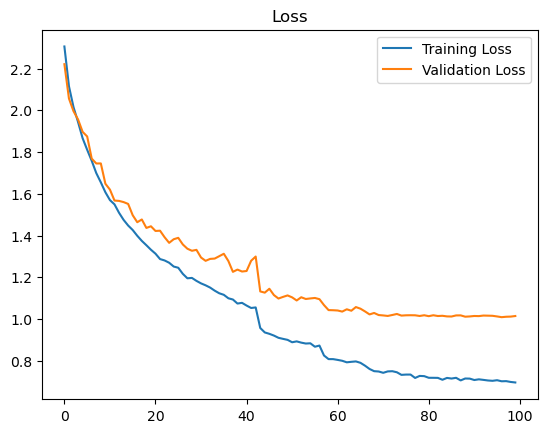

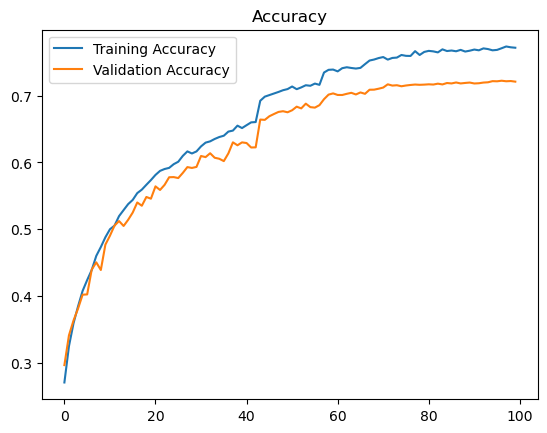

In [284]:
plot_metrics(history) 


# Testing

In [285]:
loss, acc =cnn_model.evaluate(X_test,y_test,verbose=0)
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 1.0407575368881226
Test Accuracy = 0.7140899896621704


In [286]:
predict_x=cnn_model.predict(X_test) 


548/548 [==============================] - 4s 6ms/step


In [287]:
y_test_multiclass = [labelencoder.inverse_transform([np.argmax(y)]) for y in y_test]



In [288]:
from sklearn.metrics import classification_report


# Calculate the classification report
report = classification_report(y_test_multiclass, predicted_labels)
print(report)


                               precision    recall  f1-score   support

                   background       0.06      0.07      0.07      1189
       ceramic-only collision       0.08      0.09      0.09      1153
                   cut / chop       0.07      0.07      0.07      1150
                     footstep       0.07      0.07      0.07      1142
    metal / ceramic collision       0.07      0.08      0.07      1176
    metal / plastic collision       0.06      0.06      0.06      1174
       metal / wood collision       0.06      0.07      0.07      1181
         metal-only collision       0.06      0.04      0.05      1224
                 open / close       0.05      0.06      0.05      1151
       plastic-only collision       0.06      0.06      0.06      1172
                       rustle       0.06      0.06      0.06      1186
scrub / scrape / scour / wipe       0.07      0.05      0.05      1162
                 slide object       0.08      0.08      0.08      1122
     

In [289]:
X_class_index = np.argmax(predict_x)
X_class_index

9978

In [290]:
from sklearn.metrics import precision_score, recall_score, f1_score


def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    score = f1_score(y_true, y_pred, average='samples')

    return precision, recall, score

In [291]:
precision, recall, f1score = compute_f1_score(y_test, predict_x)
print(f"Precision: {precision}")
print(f"Recall   : {recall}")
print(f"F1 score : {f1score}")

Precision: 0.7712294696468269
Recall   : 0.6530325618907963
F1 score : 0.6515186115551496


# Testing Some Test Audio Data

In [292]:
filename="D:/big data/practice/big_data_project/audio_files/P01_01_8.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mel_spectrogram_features = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
log_mel_spectrogram_scaled_features = np.mean(mel_spectrogram_features.T,axis=0)


In [293]:
print(log_mel_spectrogram_scaled_features)

[4.78554001e+01 2.88304214e+01 2.08114738e+01 1.62341785e+01
 9.05473900e+00 8.43668079e+00 1.25504074e+01 1.58599892e+01
 3.66550179e+01 1.39929398e+02 2.57578888e+02 2.36733414e+02
 2.18481140e+02 1.72652298e+02 1.65332367e+02 9.77022858e+01
 9.84326019e+01 8.07897797e+01 5.72436066e+01 7.56413879e+01
 3.89754257e+01 5.59082031e+01 7.94785614e+01 3.43168373e+01
 3.22397461e+01 2.80255165e+01 3.28438644e+01 3.46961441e+01
 2.88738976e+01 3.02409496e+01 1.83347969e+01 2.29667912e+01
 2.67467995e+01 2.34627285e+01 2.32444592e+01 2.20532589e+01
 2.24301510e+01 3.44255753e+01 2.50937328e+01 3.06049767e+01
 3.83913269e+01 2.56280403e+01 4.19835968e+01 3.13592663e+01
 1.83371372e+01 1.34899530e+01 1.17269697e+01 1.07578907e+01
 1.24704456e+01 1.14173927e+01 1.17423849e+01 1.50470676e+01
 1.47703638e+01 1.66945286e+01 1.30695858e+01 1.12229929e+01
 9.18007755e+00 1.02922964e+01 1.14947739e+01 9.07486916e+00
 1.21209612e+01 1.07844725e+01 8.62986660e+00 9.00876236e+00
 8.53186321e+00 9.495450

In [294]:
log_mel_spectrogram_scaled_features=log_mel_spectrogram_scaled_features.reshape(1,-1)
print(log_mel_spectrogram_scaled_features.shape)

(1, 128)


In [295]:
# Assuming mfccs_scaled_features is of shape (1, 40)
log_mel_spectrogram_scaled_features = log_mel_spectrogram_scaled_features[:, :35]

print(log_mel_spectrogram_scaled_features.shape)

(1, 35)


In [296]:
prediction=cnn_model.predict(log_mel_spectrogram_scaled_features)
print(prediction[0])

1/1 [==============================] - 0s 31ms/step
[0.0000000e+00 0.0000000e+00 2.0508415e-29 0.0000000e+00 0.0000000e+00
 7.4571496e-01 0.0000000e+00 2.9123446e-06 6.6609969e-32 7.5984469e-34
 1.7992758e-27 2.5428212e-01 0.0000000e+00 4.4404211e-29 0.0000000e+00]


In [297]:
predicted_class_index = np.argmax(prediction)
predicted_class_index

5

In [298]:
predicted_class = labelencoder.inverse_transform([predicted_class_index]) 
predicted_class



array(['metal / plastic collision'], dtype='<U29')

# Save model and encoder

In [299]:
import datetime

# Get the current date and time as a string
current_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Construct the filename with the current time
model_name = f"D:/big data/practice/big_data_project/src/models/model_{current_time}.h5"

# Save the model with the filename
cnn_model.save(model_name)


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [300]:
import joblib


encoder = f"D:/big data/practice/big_data_project/src/label_encoders/label_encoder_{current_time}.pkl"
# Save the LabelEncoder to a file
joblib.dump(labelencoder, encoder)

['D:/big data/practice/big_data_project/src/label_encoders/label_encoder_20231026222847.pkl']